In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import zipfile
import pandas as pd

# Specify the path to the ZIP file
zip_file_path = r"/content/drive/MyDrive/lung disease.zip"
# Specify the directory where you want to extract the contents
extracted_dir_path = r'C:\Users\karth\Downloads\lung_disease_extracted'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Generate data paths with labels
filepaths = []
labels = []

# Iterate through the extracted directories
for root, dirs, files in os.walk(extracted_dir_path):
    for f in files:
        # Get the full file path
        fpath = os.path.join(root, f)
        filepaths.append(fpath)

        # Determine the label based on the directory name
        folder_name = os.path.basename(root)
        if folder_name == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif folder_name == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif folder_name == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif folder_name == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif folder_name == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Optionally, you can clean up the extracted directory after you're done processing
# Note: Be cautious with this step, as it deletes the extracted files
# import shutil
# shutil.rmtree(extracted_dir_path)


In [ ]:
df

filepaths                labels
0      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
1      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
2      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
3      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
4      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
...                                                  ...                   ...
24974  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24975  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24976  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24977  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24978  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma

[24979 rows x 2 columns]

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 19983 validated image filenames belonging to 5 classes.
Found 2997 validated image filenames belonging to 5 classes.
Found 1999 validated image filenames belonging to 5 classes.


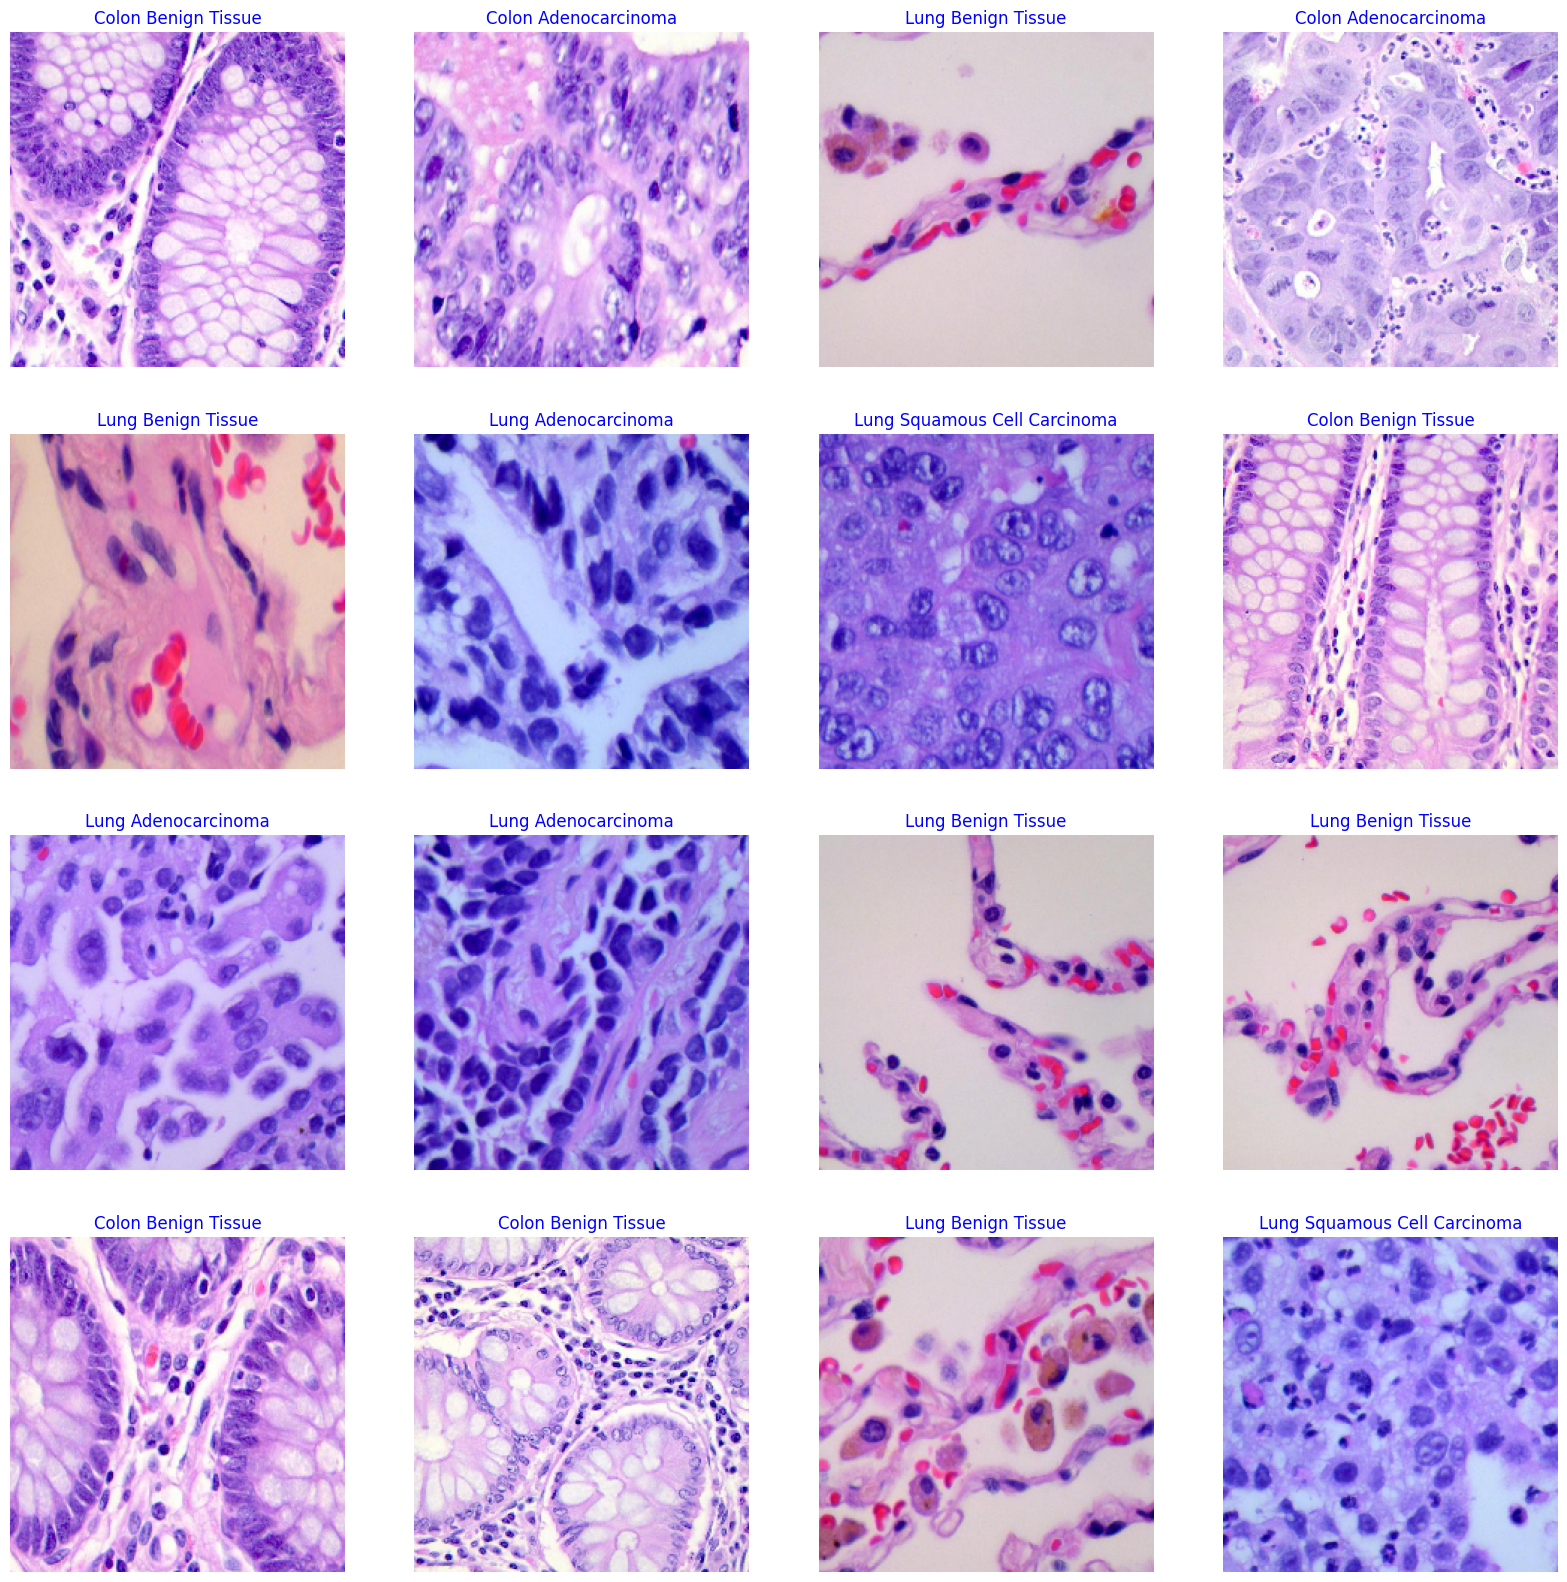

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam'''
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 5  # Assuming 5 classes for lung and colon cancer detection

# Create pre-trained model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Freeze base model layers
base_model.trainable = False

# Build the complete model
model1 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1024, activation='relu'),
    Dropout(rate=0.4),
    Dense(512, activation='relu'),
    Dropout(rate=0.4),
    Dense(class_count, activation='softmax')
])

# Compile the model with Adam optimizer and a learning rate appropriate for your task
model1.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

3rd model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 5  # Assuming 5 classes for lung and colon cancer detection

# Create pre-trained model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Freeze base model layers
base_model.trainable = False

# Build the complete model
model2 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1024, activation='relu'),
    Dropout(rate=0.4),
    Dense(512, activation='relu'),
    Dropout(rate=0.4),
    Dense(class_count, activation='sigmoid')
])

# Compile the model with Adam optimizer and a learning rate appropriate for your task
model2.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                         

In [ ]:
epochs = 12   # number of all epochs in training

history = model1.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/12
1249/1249 [==============================] - 3415s 3s/step - loss: 0.3310 - accuracy: 0.8807 - val_loss: 0.0771 - val_accuracy: 0.9693
Epoch 2/12
  78/1249 [>.............................] - ETA: 46:30 - loss: 0.1868 - accuracy: 0.9239

3rd model training

In [ ]:
epochs = 12   # number of all epochs in training

history = model2.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/12
1249/1249 [==============================] - 165s 119ms/step - loss: 0.3304 - accuracy: 0.8805 - val_loss: 0.0771 - val_accuracy: 0.9686
Epoch 2/12
1249/1249 [==============================] - 144s 116ms/step - loss: 0.1689 - accuracy: 0.9396 - val_loss: 0.0604 - val_accuracy: 0.9773
Epoch 3/12
1249/1249 [==============================] - 120s 96ms/step - loss: 0.1321 - accuracy: 0.9538 - val_loss: 0.0418 - val_accuracy: 0.9843
Epoch 4/12
1249/1249 [==============================] - 119s 95ms/step - loss: 0.1119 - accuracy: 0.9583 - val_loss: 0.0335 - val_accuracy: 0.9870
Epoch 5/12
1249/1249 [==============================] - 116s 93ms/step - loss: 0.0973 - accuracy: 0.9652 - val_loss: 0.0312 - val_accuracy: 0.9880
Epoch 6/12
1249/1249 [==============================] - 121s 97ms/step - loss: 0.0898 - accuracy: 0.9663 - val_loss: 0.0339 - val_accuracy: 0.9860
Epoch 7/12
1249/1249 [==============================] - 117s 94ms/step - loss: 0.0798 - accuracy: 0.9713 - val_loss:

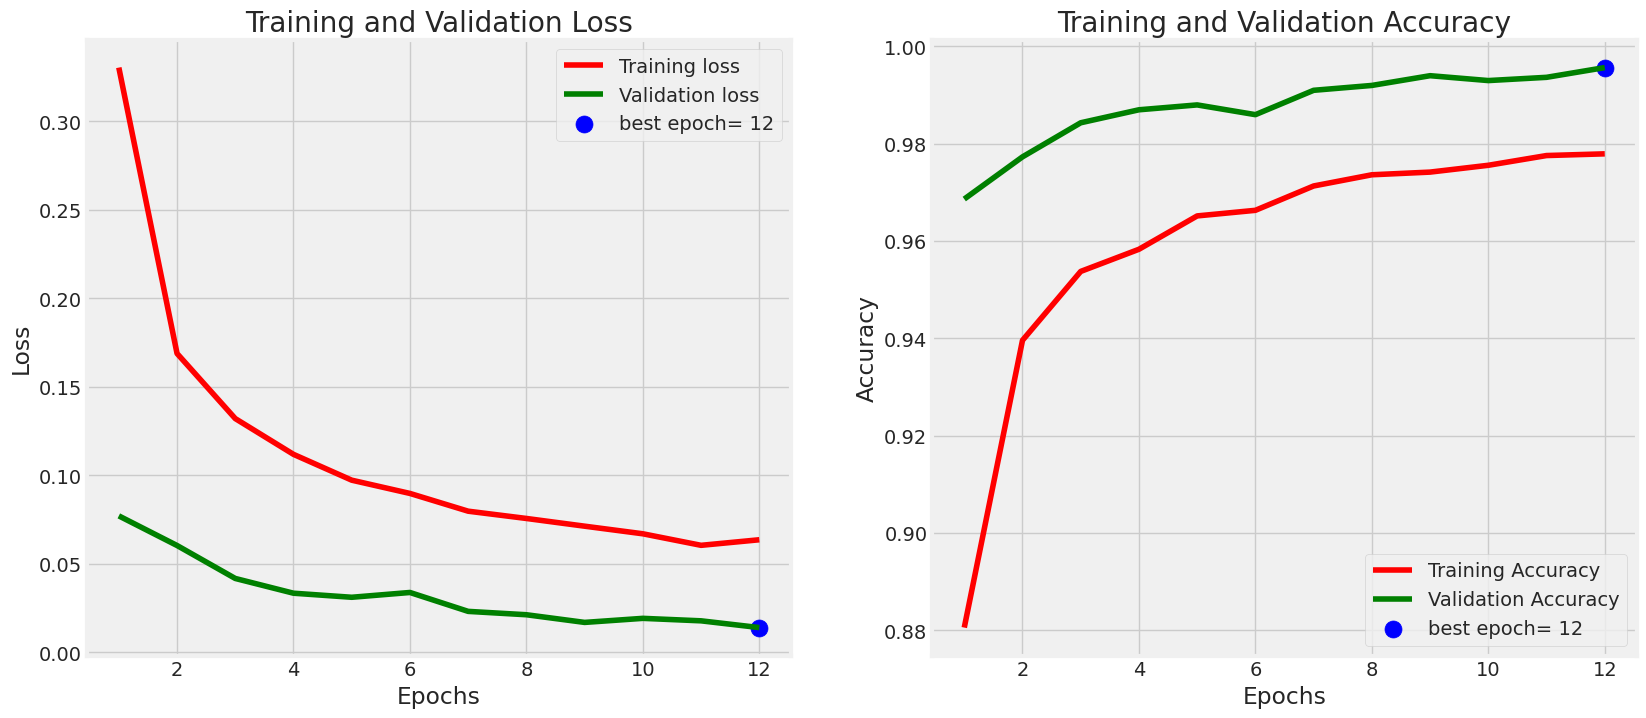

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model2.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model2.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model2.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1249/1999 [=================>............] - ETA: 1:08 - loss: 0.0060 - accuracy: 0.9988

 187/1999 [=>............................] - ETA: 2:28 - loss: 0.0141 - accuracy: 0.9957

 125/1999 [>.............................] - ETA: 2:45 - loss: 0.0181 - accuracy: 0.9935

1999/1999 [==============================] - 11s 6ms/step - loss: 0.0181 - accuracy: 0.9935
Train Loss:  0.005975127220153809
Train Accuracy:  0.9987989664077759
--------------------
Validation Loss:  0.014039793983101845
Validation Accuracy:  0.9956623315811157
--------------------
Test Loss:  0.01809823326766491
Test Accuracy:  0.9934967756271362


In [ ]:
preds = model2.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

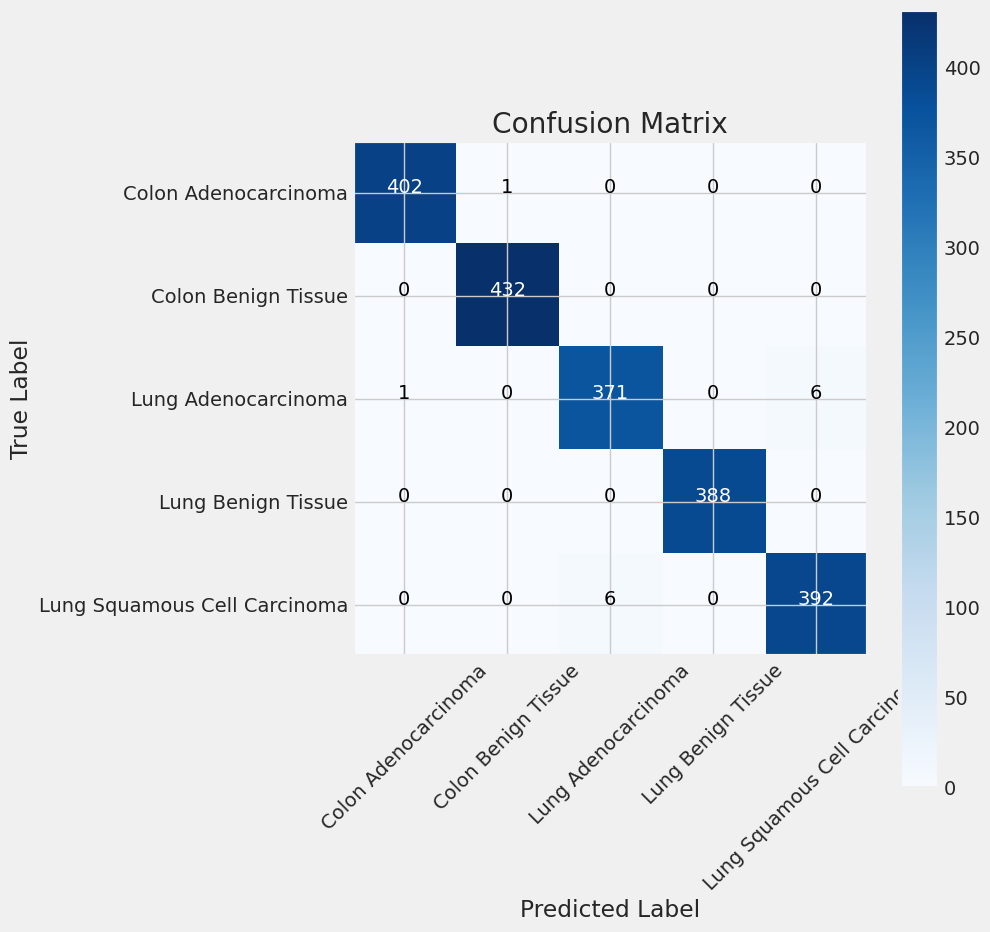

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       403
         Colon Benign Tissue       1.00      1.00      1.00       432
         Lung Adenocarcinoma       0.98      0.98      0.98       378
          Lung Benign Tissue       1.00      1.00      1.00       388
Lung Squamous Cell Carcinoma       0.98      0.98      0.98       398

                    accuracy                           0.99      1999
                   macro avg       0.99      0.99      0.99      1999
                weighted avg       0.99      0.99      0.99      1999



In [ ]:
#Save the model
model2.save('/content/drive/MyDrive/EfficientNetB3_model_mod_param_2.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/EfficientNetB3_model_mod_param_2.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/lungn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 4s 4s/step
Lung Benign Tissue


In [ ]:
predictions

array([[0.07076143, 0.00153199, 0.7592981 , 0.9999999 , 0.02593086]],
      dtype=float32)

In [ ]:
image_path = '/content/lungaca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 116ms/step
Lung Adenocarcinoma


In [ ]:
predictions

array([[0.08396059, 0.36450478, 0.9999945 , 0.00855222, 0.93084586]],
      dtype=float32)

In [ ]:
image_path = '/content/lungscc5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 51ms/step
Lung Squamous Cell Carcinoma


In [ ]:
predictions

array([[0.01638118, 0.00137134, 0.9995316 , 0.03240086, 0.9999912 ]],
      dtype=float32)

In [ ]:
image_path = '/content/colonca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 50ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9999976e-01, 4.2001948e-01, 1.0048319e-01, 7.8868106e-05,
        9.7364455e-01]], dtype=float32)

In [ ]:
image_path = '/content/colonn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 47ms/step
Colon Benign Tissue


In [ ]:
predictions

array([[1.4460966e-01, 1.0000000e+00, 1.7871941e-02, 6.4979804e-06,
        7.0256332e-04]], dtype=float32)

In [ ]:
image_path = '/content/COLON.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 91ms/step
Colon Benign Tissue


In [ ]:
predictions

array([[0.60320807, 0.99998355, 0.04669205, 0.00373759, 0.9943897 ]],
      dtype=float32)

In [ ]:
image_path = '/content/LUNG.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 57ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9589324e-01, 2.5931582e-02, 9.3651640e-01, 7.1738166e-04,
        9.8477942e-01]], dtype=float32)